In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import talib

In [2]:
# Function to split data
def split_data(data, train_size, test_size):
    if (train_size + test_size) > 1.0:
        raise ValueError("The sum of train and test sizes must not exceed 1.0")
    train_size = int(train_size * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data

In [3]:
import matplotlib.pyplot as plt
def plot_stock_data(stock_data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(time_series):
    result = adfuller(time_series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] < 0.05:
        print("The series is stationary (reject the null hypothesis of unit root).")
    else:
        print("The series is non-stationary (fail to reject the null hypothesis of unit root).")


In [5]:
def compute_technical_indicators(data):
    # Ensure the input is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    
    # Get a list of columns that are not of type 'datetime' and not of type 'object'
    cols = data.select_dtypes(exclude=['datetime', 'object']).columns

    # Convert these columns to type 'double'
    data[cols] = data[cols].astype('double')

    # Compute Technical Indicators
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['EMA_20'] = talib.EMA(data['Close'].values, timeperiod=20)
    data['RSI'] = talib.RSI(data['Close'].values, timeperiod=14)
    macd, macdsignal, macdhist = talib.MACD(data['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
    data['MACD'] = macd
    data['MACD_Signal'] = macdsignal
    data['MACD_Diff'] = macdhist
    upper, middle, lower = talib.BBANDS(data['Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    data['BB_High'] = upper
    data['BB_Middle'] = middle
    data['BB_Low'] = lower
    data['ATR'] = talib.ATR(data['High'].values, data['Low'].values, data['Close'].values, timeperiod=14)
    data['OBV'] = talib.OBV(data['Close'].values, data['Volume'].values)
    
    # Drop rows with NaN values created by the indicators
    data.dropna(inplace=True)
    
    return data

In [6]:
# Function to preprocess stock data
def preprocess_stock_data(csv_file_path):
    data = pd.read_csv(csv_file_path)
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data.set_index('Date', inplace=True)
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data = data.ffill()
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    
    def convert_volume_to_number(volume_str):
        if isinstance(volume_str, float) and np.isnan(volume_str):
            return np.nan
        if volume_str[-1] == 'K':
            return int(float(volume_str[:-1]) * 1000)
        elif volume_str[-1] == 'M':
            return int(float(volume_str[:-1]) * 1000000)
        elif volume_str[-1] == 'B':
            return int(float(volume_str[:-1]) * 1000000000)
        else:
            return int(volume_str)
    
    data["Volume"] = data["Volume"].apply(convert_volume_to_number)
    
    def convert_change_to_number(change_str):
        if isinstance(change_str, float) and np.isnan(change_str):
            return np.nan
        return float(change_str.strip('%')) / 100

    data["Change %"] = data["Change %"].apply(convert_change_to_number)
    
    def convert_str_to_number(str_value):
        if isinstance(str_value, float) and np.isnan(str_value):
            return np.nan
        return float(str_value.replace(',', ''))
    
    data['Close'] = data['Close'].apply(convert_str_to_number)
    data['Open'] = data['Open'].apply(convert_str_to_number)
    data['High'] = data['High'].apply(convert_str_to_number)
    data['Low'] = data['Low'].apply(convert_str_to_number)
    
    data = data.sort_values('Date', ascending=True)
    return data

In [7]:

# Load and preprocess data
data = preprocess_stock_data('../../DATASET/VHM.csv')
data = compute_technical_indicators(data)
data['Date_index'] = data['Date']
data.set_index('Date_index', inplace=True)
print(data)

                 Date    Close     Open     High      Low     Volume  \
Date_index                                                             
2019-04-03 2019-04-03  69173.0  69323.0  69323.0  68496.0   365750.0   
2019-04-04 2019-04-04  69173.0  69699.0  69774.0  68646.0   636410.0   
2019-04-05 2019-04-05  69624.0  69549.0  70075.0  69248.0   590540.0   
2019-04-06 2019-04-06  69624.0  69549.0  70075.0  69248.0   590540.0   
2019-04-07 2019-04-07  69624.0  69549.0  70075.0  69248.0   590540.0   
...               ...      ...      ...      ...      ...        ...   
2024-05-27 2024-05-27  39800.0  39850.0  40050.0  39750.0  4620000.0   
2024-05-28 2024-05-28  39950.0  39850.0  40050.0  39750.0  5560000.0   
2024-05-29 2024-05-29  39450.0  40000.0  40100.0  39450.0  8029999.0   
2024-05-30 2024-05-30  39000.0  39450.0  39500.0  39000.0  6420000.0   
2024-05-31 2024-05-31  38850.0  39200.0  39650.0  38850.0  5850000.0   

            Change %    SMA_20        EMA_20        RSI        

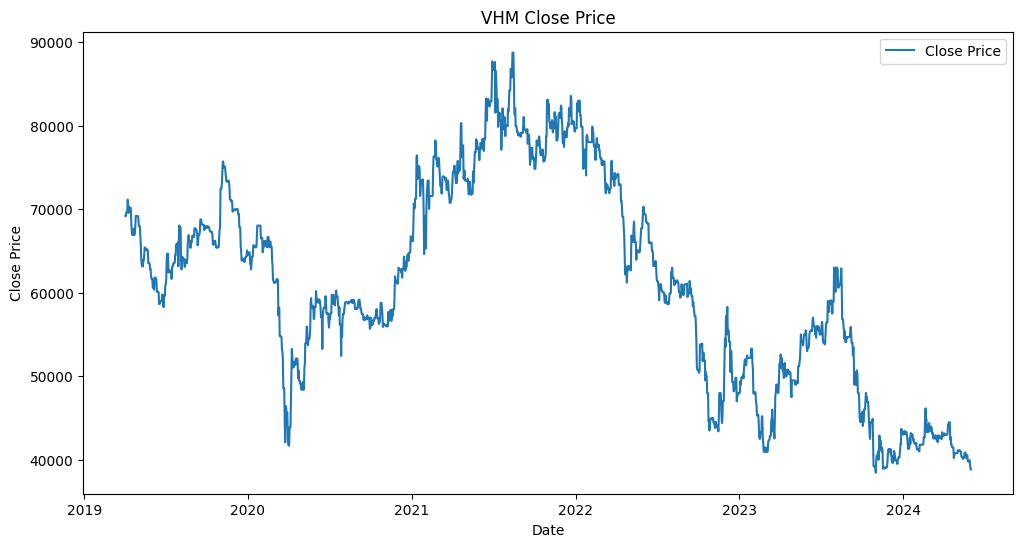

In [8]:
# Plot stock data
plot_stock_data(data, 'VHM Close Price')


In [9]:
# Split data
train_data, test_data = split_data(data, train_size=0.7, test_size=0.3)

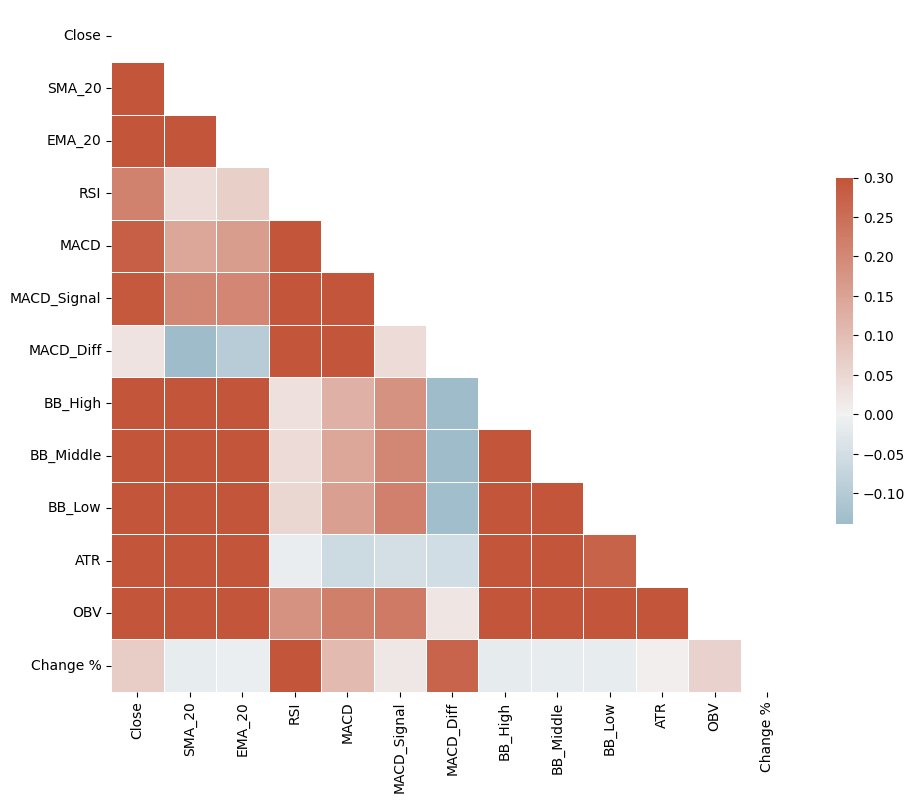

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select 'Close' and the technical indicators
selected_data = data[['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Middle', 'BB_Low', 'ATR', 'OBV', 'Change %']]

# Compute the correlation matrix
corr = selected_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [11]:
# Define endogenous and exogenous variables
endog_train, endog_test = train_data['Close'], test_data['Close']
exog_train = train_data[['SMA_20', 'MACD_Signal']]
exog_test = test_data[['SMA_20', 'MACD_Signal']]

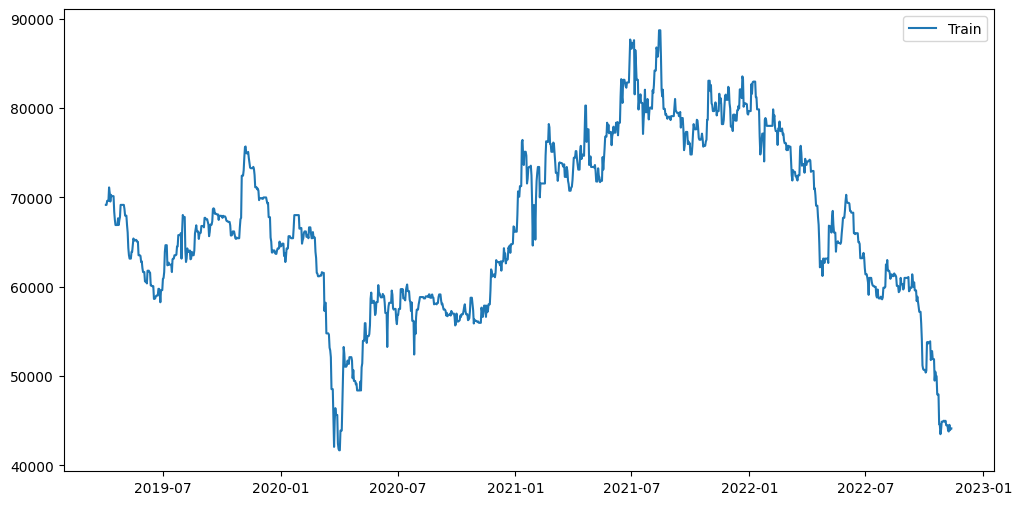

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(endog_train.index, endog_train, label='Train')
plt.legend()
plt.show()


In [13]:
# Scale the exogenous variables
scaler = StandardScaler()
exog_train_scaled = scaler.fit_transform(exog_train)
exog_test_scaled = scaler.transform(exog_test)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [15]:
check_stationarity(train_data['Close'])
check_stationarity(train_data['MACD_Signal'])
check_stationarity(train_data['SMA_20'])


ADF Statistic: -0.928771
p-value: 0.778350
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is non-stationary (fail to reject the null hypothesis of unit root).
ADF Statistic: -5.067925
p-value: 0.000016
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).
ADF Statistic: -1.459577
p-value: 0.553405
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is non-stationary (fail to reject the null hypothesis of unit root).


In [16]:
train_data['Close_diff'] = train_data['Close'].diff()
train_data['SMA_20_diff'] = train_data['SMA_20'].diff()
check_stationarity(train_data['Close_diff'].dropna())
check_stationarity(train_data['SMA_20_diff'].dropna())

ADF Statistic: -8.770964
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).
ADF Statistic: -4.571497
p-value: 0.000146
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).


/var/folders/6_/q31jqlzd6195rlvq5qgn5qn80000gn/T/ipykernel_77613/3119333373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Close_diff'] = train_data['Close'].diff()
/var/folders/6_/q31jqlzd6195rlvq5qgn5qn80000gn/T/ipykernel_77613/3119333373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['SMA_20_diff'] = train_data['SMA_20'].diff()


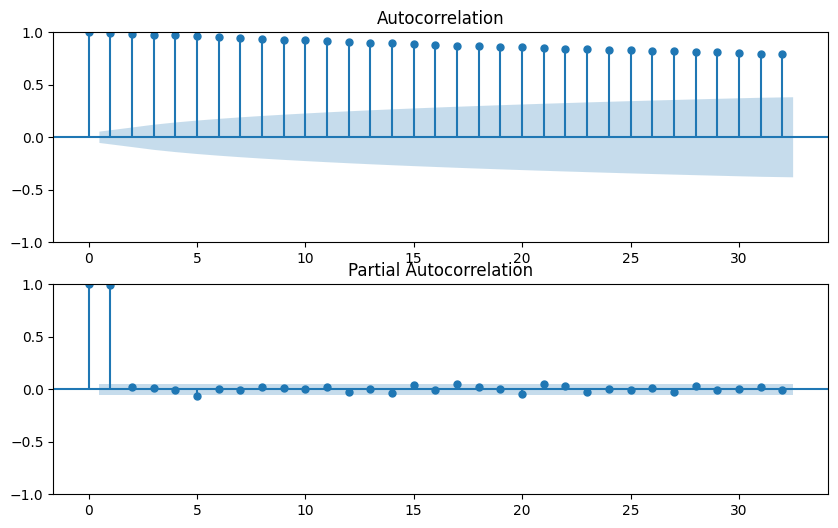

In [17]:
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(211)
plot_acf(endog_train, ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(endog_train, ax=ax2)
plt.show()

In [18]:
# Find the best ARIMA order
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = sm.tsa.ARIMA(endog=endog_train, exog=exog_train_scaled, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

print(f"Best ARIMAX Model: {best_pdq} with AIC: {best_aic}")

/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packag

Best ARIMAX Model: (2, 0, 1) with AIC: 21861.856617370293


In [19]:
model = sm.tsa.ARIMA(endog_train, exog=exog_train_scaled, order=best_pdq)
model_fit = model.fit()

/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/willphan_43/.pyenv/versions/3.11

In [20]:
def forecast_exog_variable(variable, train_data, forecast_period, p_values, d_values, q_values):
    pdq = list(itertools.product(p_values, d_values, q_values))
    best_aic = np.inf
    best_pdq = None
    best_model = None
    
    for param in pdq:
        try:
            model = sm.tsa.ARIMA(train_data[variable], order=param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_model = results
        except:
            continue
    
    print(f"Best ARIMA Model for {variable}: {best_pdq} with AIC: {best_aic}")
    exog_forecast = best_model.forecast(steps=forecast_period)
    return exog_forecast

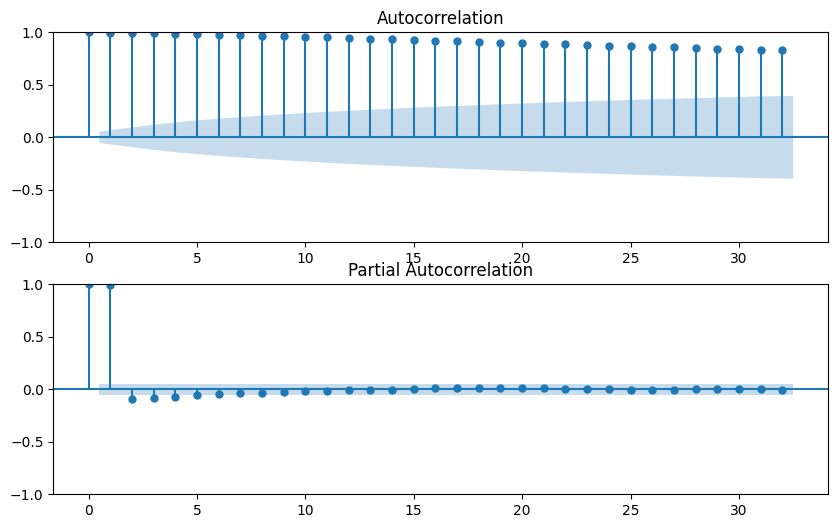

ADF Statistic: -1.459577
p-value: 0.553405
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is non-stationary (fail to reject the null hypothesis of unit root).
ADF Statistic: -14.139048
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).


In [21]:
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(211)
plot_acf(exog_train['SMA_20'], ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(exog_train['SMA_20'], ax=ax2)
plt.show()
# Forecast the exogenous variables on the test set
check_stationarity(train_data['SMA_20'])
check_stationarity(train_data['SMA_20'].diff().dropna().diff().dropna())
# Forecast

In [22]:
sma_forecast = forecast_exog_variable('SMA_20', exog_train, len(test_data), [2], [1], [0])
print(sma_forecast)

Best ARIMA Model for SMA_20: (2, 1, 0) with AIC: 15178.923485027864
2022-11-13    44294.061070
2022-11-14    44139.727187
2022-11-15    44000.402578
2022-11-16    43874.627016
2022-11-17    43761.082899
                  ...     
2024-05-27    42707.056469
2024-05-28    42707.056469
2024-05-29    42707.056469
2024-05-30    42707.056469
2024-05-31    42707.056469
Freq: D, Name: predicted_mean, Length: 566, dtype: float64


/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


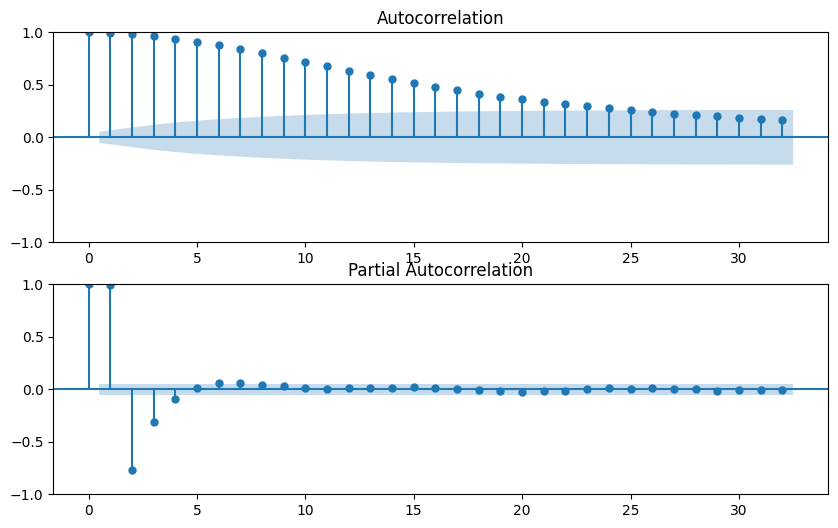

ADF Statistic: -5.067925
p-value: 0.000016
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).
ADF Statistic: -10.971904
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).


In [23]:
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(211)
plot_acf(exog_train['MACD_Signal'], ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(exog_train['MACD_Signal'], ax=ax2)
plt.show()
check_stationarity(train_data['MACD_Signal'])
check_stationarity(train_data['MACD_Signal'].diff().dropna().diff().dropna())


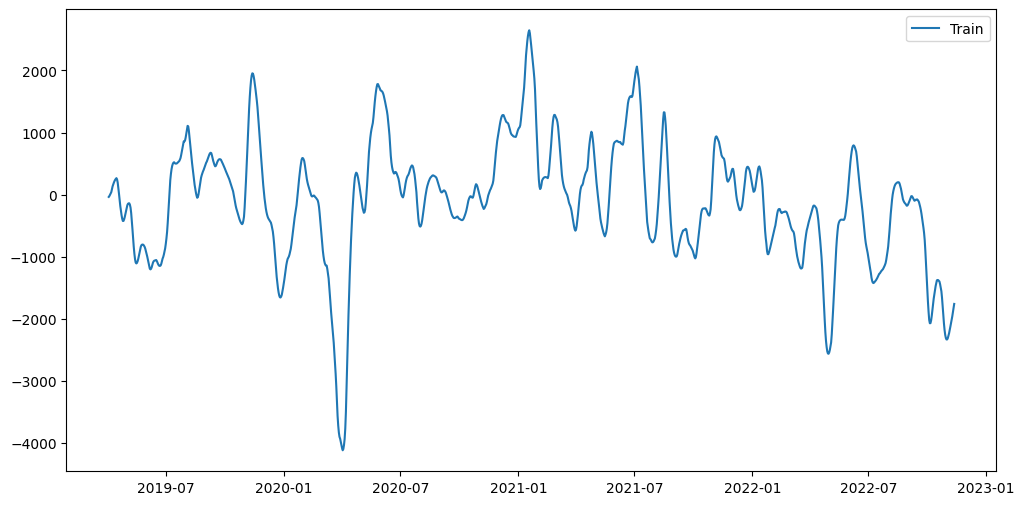

Best ARIMA Model for MACD_Signal: (2, 0, 0) with AIC: 11734.961351504455
2022-11-13   -1678.262948
2022-11-14   -1588.965338
2022-11-15   -1491.433253
2022-11-16   -1386.629911
2022-11-17   -1275.543463
                 ...     
2024-05-27    -110.623796
2024-05-28    -110.653941
2024-05-29    -110.684206
2024-05-30    -110.714366
2024-05-31    -110.744200
Freq: D, Name: predicted_mean, Length: 566, dtype: float64
Date_index
2022-11-13   -1686.026372
2022-11-14   -1614.565396
2022-11-15   -1553.312695
2022-11-16   -1474.197374
2022-11-17   -1336.012501
                 ...     
2024-05-27    -317.250028
2024-05-28    -320.807040
2024-05-29    -329.617117
2024-05-30    -347.686098
2024-05-31    -372.211890
Name: MACD_Signal, Length: 566, dtype: float64


/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [24]:
# plot exog train
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['MACD_Signal'], label='Train')
plt.legend()
plt.show()
macd_signal_forecast = forecast_exog_variable('MACD_Signal', exog_train, len(test_data), [2], [0], [0] )
print(macd_signal_forecast)
print(exog_test['MACD_Signal'])

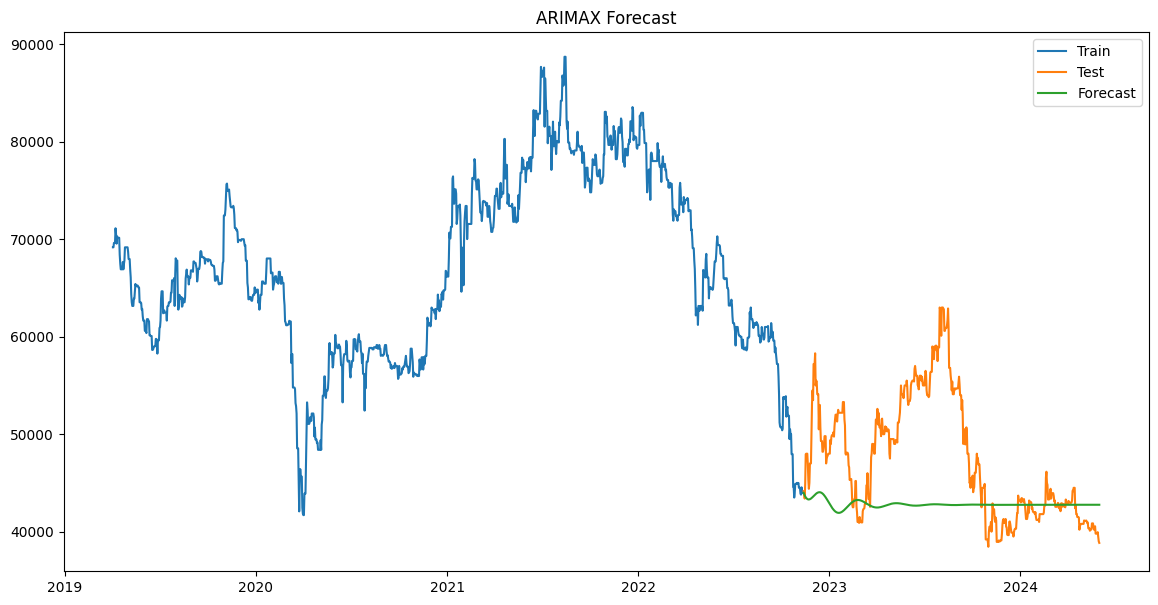

In [25]:
exog_forecast = pd.DataFrame({
    'SMA_20': sma_forecast,
    'MACD_Signal': macd_signal_forecast
})
exog_forecast_scaled = scaler.transform(exog_forecast)
# Forecast the endogenous variable on the test set
endog_forecast_test = model_fit.forecast(steps=len(exog_test), exog=exog_forecast_scaled,index=exog_test.index)

# Plot the forecasted values
plt.figure(figsize=(14, 7))
plt.plot(endog_train, label='Train')
plt.plot(endog_test, label='Test')
plt.plot(endog_forecast_test, label='Forecast')
plt.title('ARIMAX Forecast')
plt.legend()
plt.show()

In [26]:
print(exog_test)
print(exog_forecast)

             SMA_20  MACD_Signal
Date_index                      
2022-11-13  44442.5 -1686.026372
2022-11-14  44412.5 -1614.565396
2022-11-15  44407.5 -1553.312695
2022-11-16  44452.5 -1474.197374
2022-11-17  44605.0 -1336.012501
...             ...          ...
2024-05-27  40347.5  -317.250028
2024-05-28  40300.0  -320.807040
2024-05-29  40225.0  -329.617117
2024-05-30  40157.5  -347.686098
2024-05-31  40082.5  -372.211890

[566 rows x 2 columns]
                  SMA_20  MACD_Signal
2022-11-13  44294.061070 -1678.262948
2022-11-14  44139.727187 -1588.965338
2022-11-15  44000.402578 -1491.433253
2022-11-16  43874.627016 -1386.629911
2022-11-17  43761.082899 -1275.543463
...                  ...          ...
2024-05-27  42707.056469  -110.623796
2024-05-28  42707.056469  -110.653941
2024-05-29  42707.056469  -110.684206
2024-05-30  42707.056469  -110.714366
2024-05-31  42707.056469  -110.744200

[566 rows x 2 columns]


566


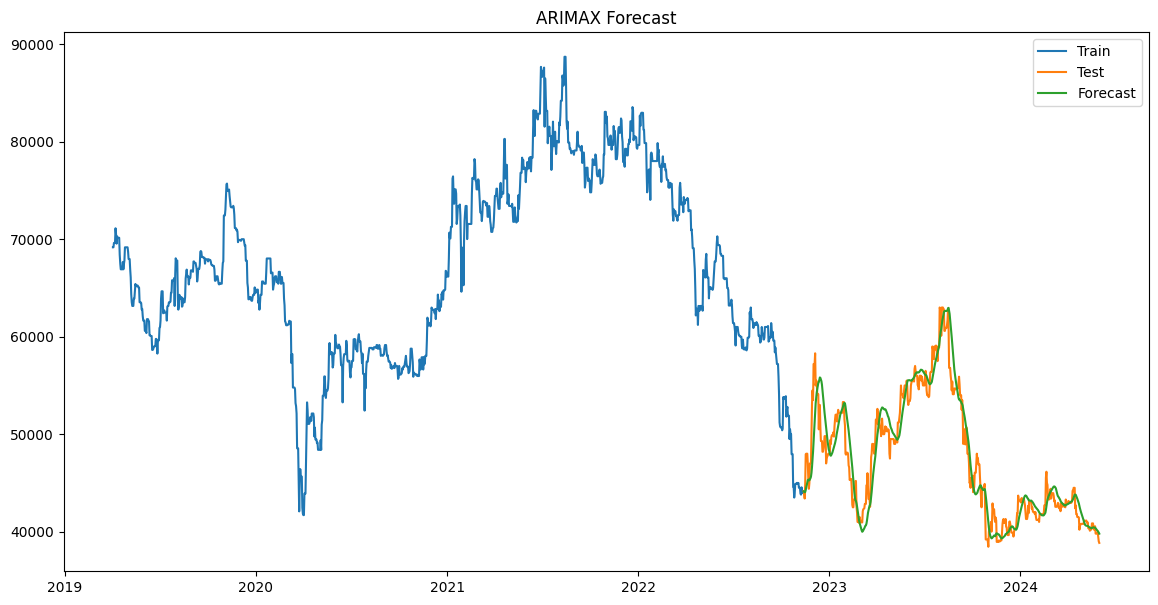

In [27]:
exog_test = test_data[['SMA_20', 'MACD_Signal']]
exog_test_scaled = scaler.transform(exog_test)
print(len(exog_test_scaled))
# Forecast the endogenous variable on the test set
endog_forecast = model_fit.forecast(steps=len(test_data), exog=exog_test_scaled,index=test_data.index)
# Plot the forecasted values
plt.figure(figsize=(14, 7))
plt.plot(endog_train, label='Train')
plt.plot(endog_test, label='Test')
plt.plot(endog_forecast, label='Forecast')
plt.title('ARIMAX Forecast')
plt.legend()
plt.show()

/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packag

Best ARIMA Model for SMA_20: (2, 1, 0) with AIC: 21456.744506376413
Best ARIMA Model for MACD_Signal: (2, 0, 0) with AIC: 16631.72160730375


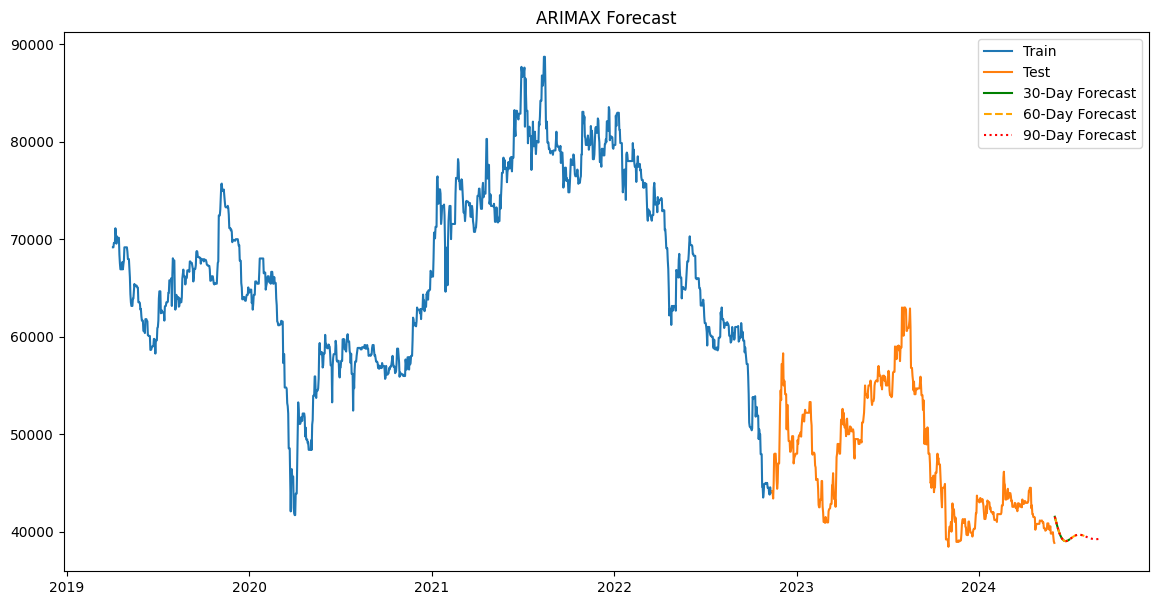

In [28]:

# Forecast the exogenous variables for next 90 days since the last date in the dataset

sma_forecast = forecast_exog_variable('SMA_20', data, 90, [2], [1], [0])
macd_signal_forecast = forecast_exog_variable('MACD_Signal', data, 90, [2], [0], [0])
# Create a DataFrame with the forecasted exogenous variables
exog_forecast = pd.DataFrame({'SMA_20': sma_forecast, 'MACD_Signal': macd_signal_forecast})
exog_forecast_scaled = scaler.transform(exog_forecast)
# Forecast the endogenous variable for the next 90 days
endog_forecast = model_fit.forecast(steps=90, exog=exog_forecast_scaled, index=pd.date_range(start=data.index.max()+ pd.Timedelta(days=1), periods=90, freq='D'))
# Split the forecast into three parts
endog_forecast_30 = endog_forecast.iloc[:30]
endog_forecast_60 = endog_forecast.iloc[:60]
endog_forecast_90 = endog_forecast 

# Plot the forecasted values with different styles
plt.figure(figsize=(14, 7))
plt.plot(endog_train, label='Train')
plt.plot(endog_test, label='Test')

# Plot each forecast part with different styles for clarity
plt.plot(endog_forecast_30, label='30-Day Forecast', color='green')
plt.plot(endog_forecast_60, label='60-Day Forecast', color='orange', linestyle='--')
plt.plot(endog_forecast_90, label='90-Day Forecast', color='red', linestyle=':')

plt.title('ARIMAX Forecast')
plt.legend()
plt.show()

In [29]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error
# print(endog_forecast_test)
rmse = np.sqrt(mean_squared_error(endog_test, endog_forecast_test))
print(f"RMSE: {rmse}")
# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(endog_test, endog_forecast_test)
mape = mean_absolute_percentage_error(endog_test, endog_forecast_test)
print(f"MAPE: {mape}")
# Calculate MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(endog_test, endog_forecast_test)
print(f"MAE: {mae}")


RMSE: 7695.317377320438
MAPE: 10.952661495131204
MAE: 5694.873938084736
